# Playground Series S3e25

## Overview

The input data contains information about the physical/chemical properties of the mineral.
The goal is to predict the hardness of the mineral (Mohs hardness).

### Metrics

In this challenge Median Absolute Error (MedAE) is used.
It is defined as:
$$
MedAE(y,\hat{y}) = median(|y_i - \hat{y}_i|
$$

## Libraries import

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, KFold, cross_val_score

from sklearn.compose import TransformedTargetRegressor

from sklearn.ensemble import StackingRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import make_scorer, median_absolute_error, accuracy_score


## Data load

In [2]:
RANDOM_STATE = 271123

In [3]:
initial_train = pd.read_csv('train.csv')
initial_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## EDA

Firstly, let's see the train data itself and some info about it.

In [4]:
initial_train.head(10)

id  allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0   0               100.0       0.841611             10.000000       4.800000   
1   1               100.0       7.558488             10.000000       4.800000   
2   2                76.0       8.885992             15.600000       5.600000   
3   3               100.0       8.795296             10.000000       4.800000   
4   4               116.0       9.577996             11.600000       4.800000   
5   5               131.0      24.529328             21.833333       4.666667   
6   6                50.0       3.253996             10.000000       4.800000   
7   7                30.0       2.701748              6.000000       4.000000   
8   8               120.0      14.632000             12.000000       4.800000   
9   9                97.0      13.477328             12.812500       5.000000   

   atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0             20.612526          11.088100            2.766000   
1             20.298893          12.040830            2.755000   
2             33.739258          12.086300            2.828000   
3             20.213349          10.948500            2.648000   
4             24.988133          11.824480            2.766000   
5             50.131500          11.948200            2.858333   
6             20.077018          11.023840            2.727000   
7             11.663548          12.415840            2.766000   
8             24.808518          11.331820            2.870000   
9             24.988133          11.037175            2.818750   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0               1.732000               0.860000         0.496070   
1               1.631000               0.910000         0.492719   
2               1.788000               0.864000         0.481478   
3               1.626000               0.936000         0.489272   
4               1.682000               0.896000         0.492736   
5               1.758333               0.896667         0.466388   
6               1.767000               0.880000         0.499010   
7               1.495000               0.710000         0.618493   
8               1.718500               0.910000         0.492736   
9               1.601250               0.881250         0.493192   

   density_Average  Hardness  
0          0.91457       6.0  
1          0.71760       6.5  
2          1.50633       2.5  
3          0.78937       6.0  
4          1.86481       6.0  
5          2.94712       6.0  
6          0.80631       2.0  
7          0.41631       4.0  
8          1.96268       6.0  
9          1.10889       5.8

In [5]:
initial_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


As we can see, there are 12 columns including id of the mineral. All of them (except id) has float64 type. The target of the dataset is 12th column - ***hardness***.
Features contains physical properties (electrons, valency, density and etc.)
There is neither missing values nor duplicates as for every playground series dataset.
Consequently, we can move to the exploration.

In [6]:
train = initial_train.drop('id', axis=1)

In [7]:
train.describe()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
count        10407.000000   10407.000000          10407.000000   10407.000000   
mean           128.053516      14.491342             17.033222       4.546789   
std            224.123776      15.972877             10.468734       0.690864   
min              0.000000       0.000000              0.000000       0.000000   
25%             68.000000       7.558488             10.000000       4.000000   
50%            100.000000      10.650000             12.600000       4.714286   
75%            131.000000      16.676996             22.000000       4.800000   
max          15300.000000     643.093804             67.000000       6.000000   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
count          10407.000000       10407.000000        10407.000000   
mean              37.507703          10.938308            2.607662   
std               26.012313           1.408276            0.334906   
min                0.000000           0.000000            0.000000   
25%               20.298893          10.590660            2.530000   
50%               26.203827          11.202760            2.706000   
75%               48.719500          11.670725            2.805000   
max              167.400000          15.245810            3.443000   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
count           10407.000000           10407.000000     10407.000000   
mean                1.731330               0.944132         0.493349   
std                 0.192481               0.180017         0.063080   
min                 0.000000               0.000000         0.000000   
25%                 1.672500               0.864000         0.476196   
50%                 1.732727               0.915556         0.488550   
75%                 1.800000               0.981667         0.496070   
max                 2.250000               1.615840         0.825990   

       density_Average      Hardness  
count     10407.000000  10407.000000  
mean          2.132984      4.647126  
std           1.936656      1.680525  
min           0.000000      1.000000  
25%           0.814800      3.000000  
50%           1.351550      5.500000  
75%           2.741550      6.000000  
max          10.970000     10.000000

In [8]:
feature_cols = train.columns

In [9]:
feature_cols

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

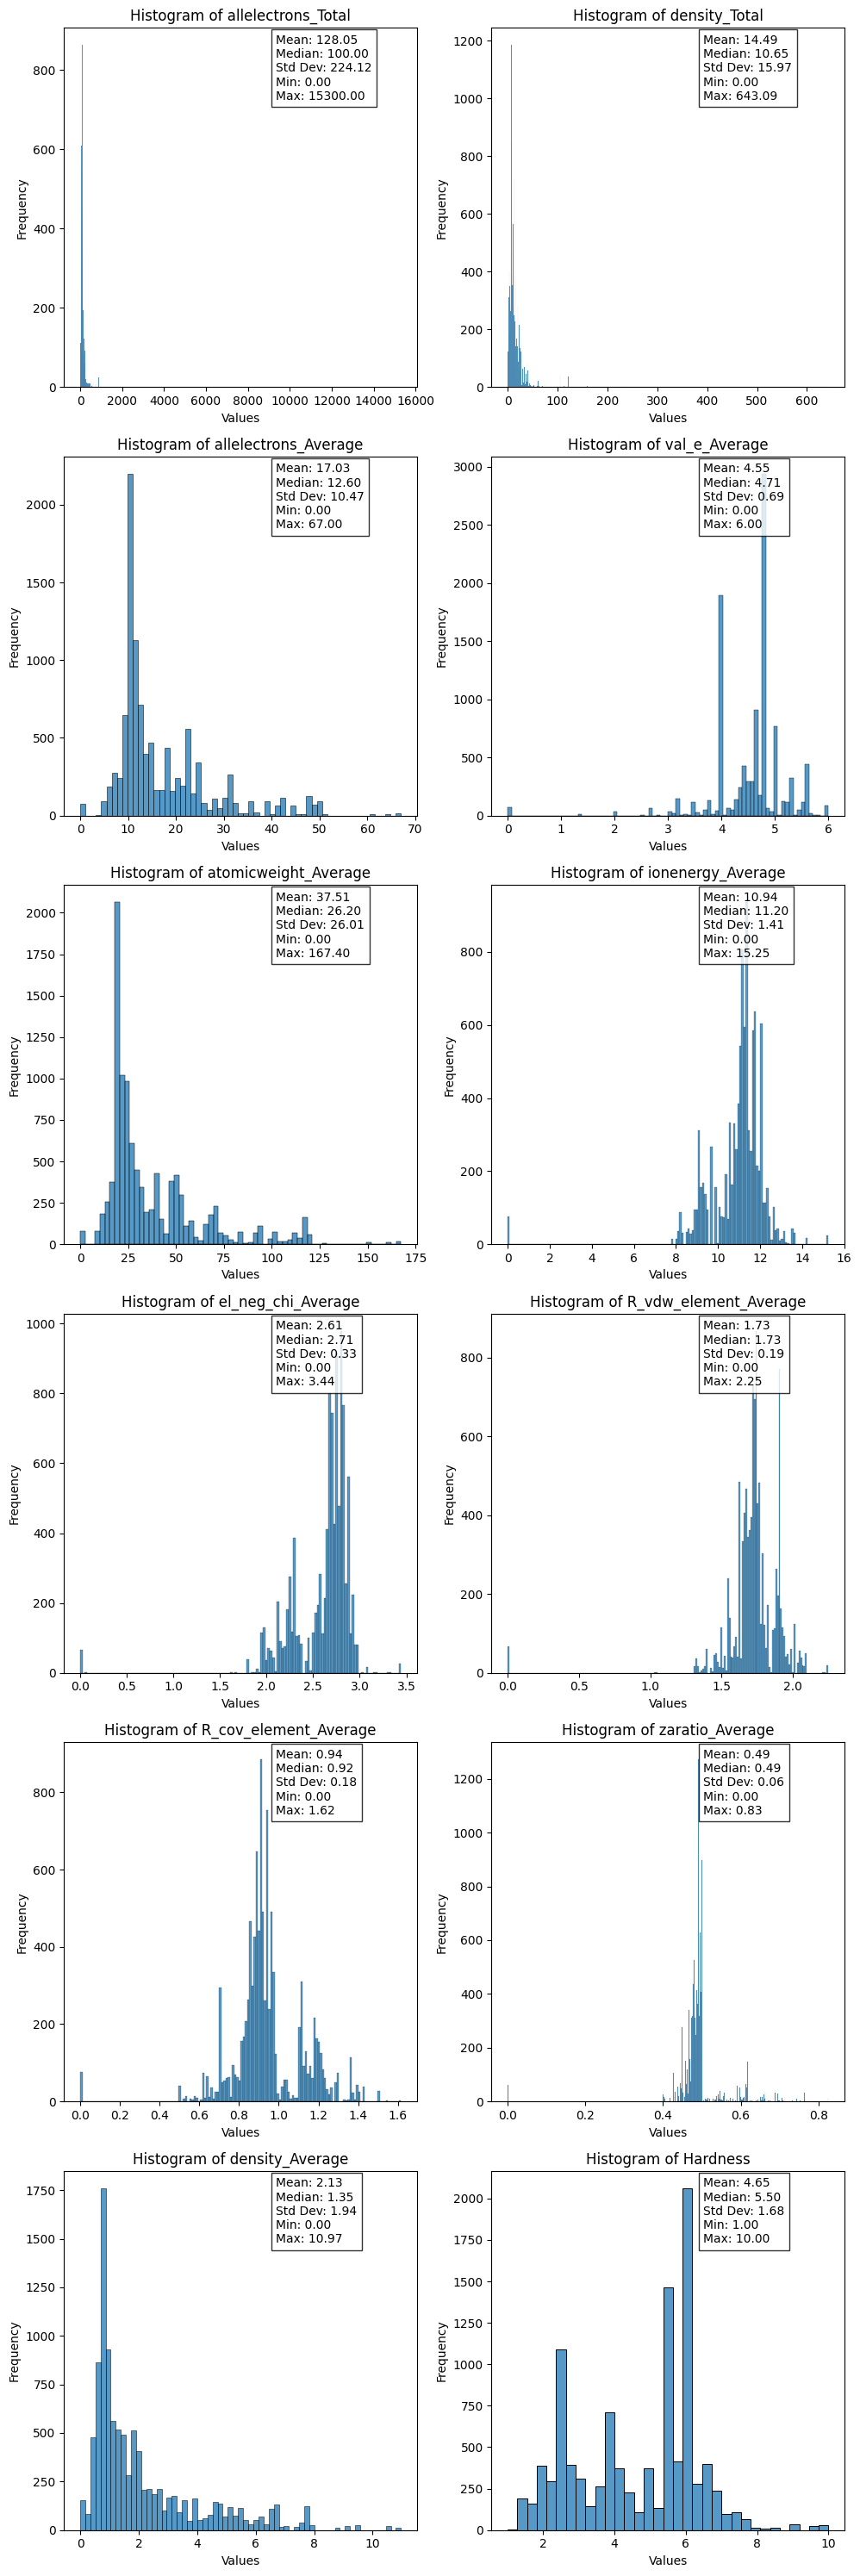

In [10]:
num_plots = len(feature_cols)
num_rows = num_plots // 2 if num_plots % 2 == 0 else num_plots // 2 + 1

plt.figure(figsize=(10, 5 * num_rows))

for i, column in enumerate(feature_cols, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(initial_train[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    
    stats = initial_train[column].describe()
    info_text = f"Mean: {stats['mean']:.2f}\nMedian: {stats['50%']:.2f}\nStd Dev: {stats['std']:.2f}\nMin: {stats['min']:.2f}\nMax: {stats['max']:.2f}"
    
    plt.text(0.6, 0.8, info_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

There are some columns with 0 as electrons, density, valency and others. 

As we can see, several features are highly skewed. To reduce the skeweness, let's transform it logarithmically.

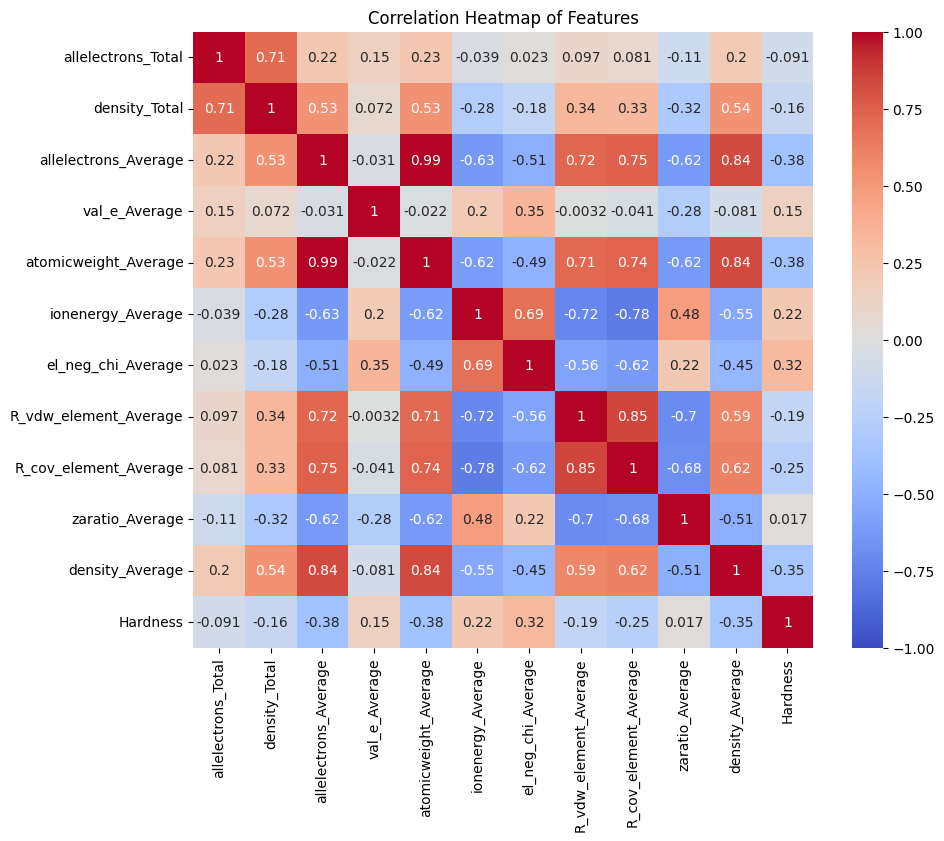

In [16]:
correlation_matrix = train_cleaned[feature_cols].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Heatmap of Features')
plt.show()

Let's clean the fatures and delete highly correlated ones.

As we can see, there are several correlated features:
- average number of electrons and atomic weight
- average density and both electrons and atomic weight
- covalent radius and van der Waal's radius

Thus, let's delete density and number of electrons as well as covalent radius.

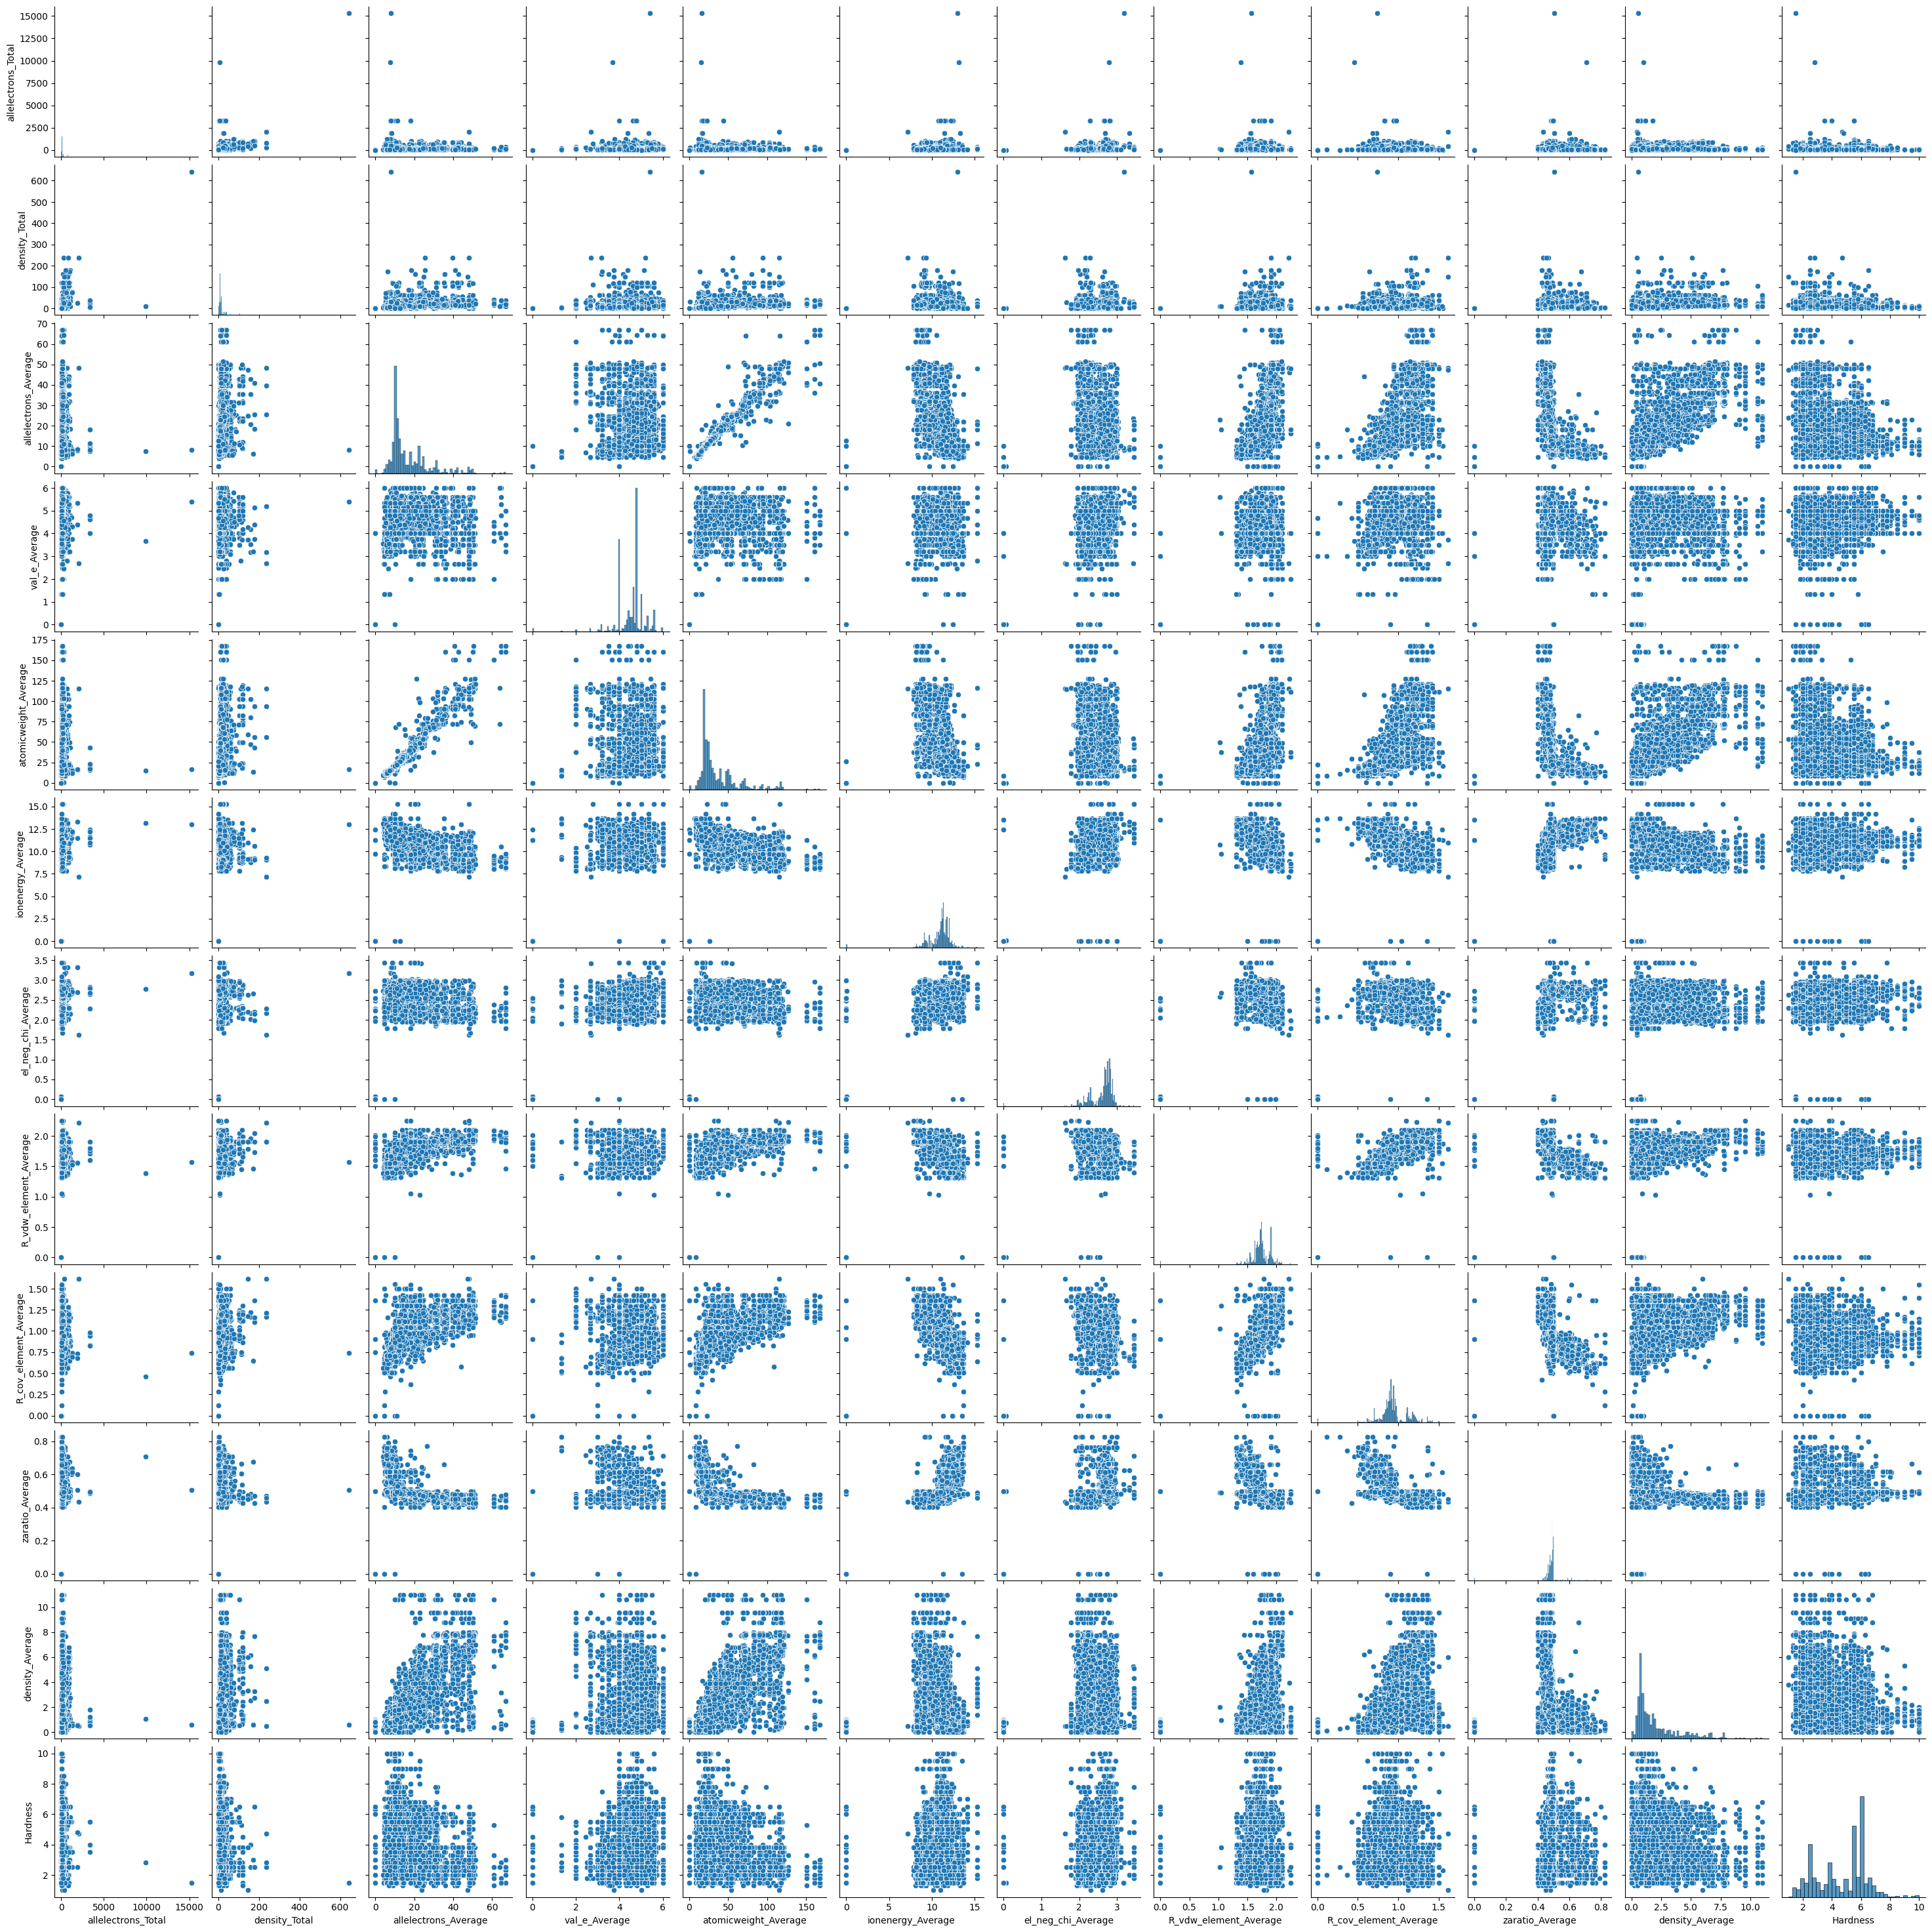

In [33]:
sns.pairplot(train)

In [36]:
X = train.drop('Hardness', axis=1)
y = train['Hardness']

### Binary Classification

Let's divide the target to 2 classes, based on the [Prediction of Mohs Hardness with Machine Learning Methods Using Compositional Features](https://par.nsf.gov/biblio/10187152)

In [35]:
def binary_class(y):
    c0 = (y <= 5.5)
    c1 = (5.5 < y)
    return c0 * 0 + c1 * 1

In [44]:
binary_y = binary_class(y)

In [51]:
accuracy_scorer = make_scorer(accuracy_score)

param_dist = {
    'learning_rate': uniform(0.001, 0.1),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(1, 10),
    'iterations': randint(50, 200)
}

catboost_model = CatBoostClassifier()

randomized_search = RandomizedSearchCV(
    catboost_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring=accuracy_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X, binary_y)

best_binary_score = randomized_search.best_score_
best_binary_clf = randomized_search.best_estimator_
print(f"Best Score for binary classification:\n{best_binary_score}")

22:	learn: 0.5191329	total: 138ms	remaining: 801ms
23:	learn: 0.5171754	total: 145ms	remaining: 803ms
24:	learn: 0.5155657	total: 154ms	remaining: 811ms
25:	learn: 0.5136715	total: 162ms	remaining: 818ms
26:	learn: 0.5118135	total: 166ms	remaining: 799ms
27:	learn: 0.5104990	total: 174ms	remaining: 802ms
28:	learn: 0.5081322	total: 178ms	remaining: 787ms
29:	learn: 0.5066141	total: 182ms	remaining: 770ms
30:	learn: 0.5058034	total: 185ms	remaining: 753ms
31:	learn: 0.5049523	total: 195ms	remaining: 762ms
32:	learn: 0.5034416	total: 198ms	remaining: 745ms
33:	learn: 0.5014855	total: 203ms	remaining: 733ms
34:	learn: 0.5004234	total: 216ms	remaining: 754ms
35:	learn: 0.4997238	total: 220ms	remaining: 739ms
36:	learn: 0.4985952	total: 231ms	remaining: 750ms
37:	learn: 0.4977645	total: 235ms	remaining: 735ms
38:	learn: 0.4967788	total: 240ms	remaining: 725ms
39:	learn: 0.4957259	total: 244ms	remaining: 715ms
40:	learn: 0.4951742	total: 248ms	remaining: 701ms
41:	learn: 0.4943688	total: 252

### Ternary classification

Let's divide the target to 3 classes, based on the [Prediction of Mohs Hardness with Machine Learning Methods Using Compositional Features](https://par.nsf.gov/biblio/10187152)

In [48]:
def ternary_class(y):
    c0 = (y <= 4.0)
    c1 = (4.0 < y) & (y <= 7.0)
    c2 = (7.0 < y)
    return c0 * 0 + c1 * 1 + c2 * 2

In [49]:
ternary_y = ternary_class(y)

In [65]:
catboost_model = CatBoostClassifier()

randomized_search = RandomizedSearchCV(
    catboost_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring=accuracy_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X, ternary_y)

best_ternary_score = randomized_search.best_score_
best_ternary_clf = randomized_search.best_estimator_
print(f"Best Score for ternary classification:\n{best_ternary_score}")

0:	learn: 1.0219089	total: 15.7ms	remaining: 2.15s
1:	learn: 0.9600726	total: 22.2ms	remaining: 1.51s
2:	learn: 0.9101711	total: 27.9ms	remaining: 1.25s
3:	learn: 0.8671169	total: 32.4ms	remaining: 1.08s
4:	learn: 0.8305379	total: 37.6ms	remaining: 1000ms
5:	learn: 0.8004461	total: 43.1ms	remaining: 947ms
6:	learn: 0.7725131	total: 47.8ms	remaining: 895ms
7:	learn: 0.7479976	total: 52.8ms	remaining: 858ms
8:	learn: 0.7267217	total: 57.3ms	remaining: 821ms
9:	learn: 0.7082114	total: 62ms	remaining: 794ms
10:	learn: 0.6919511	total: 66.8ms	remaining: 771ms
11:	learn: 0.6776617	total: 71.6ms	remaining: 751ms
12:	learn: 0.6648399	total: 76.4ms	remaining: 735ms
13:	learn: 0.6529603	total: 81.5ms	remaining: 722ms
14:	learn: 0.6432160	total: 86ms	remaining: 705ms
15:	learn: 0.6333301	total: 91ms	remaining: 694ms
16:	learn: 0.6246811	total: 95.9ms	remaining: 682ms
17:	learn: 0.6164032	total: 101ms	remaining: 672ms
18:	learn: 0.6092910	total: 106ms	remaining: 664ms
19:	learn: 0.6027302	total: 1

### Regression

In [60]:
medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

catboost_model = CatBoostRegressor()

randomized_search = RandomizedSearchCV(
    catboost_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=medae_scorer,
    random_state=42,
    n_jobs=-1
)

randomized_search.fit(X, y)
best_reg_score = randomized_search.best_score_
best_reg = randomized_search.best_estimator_
print(f"Best Score for regression:\n{-best_reg_score}")

16:	learn: 1.5647047	total: 77.9ms	remaining: 550ms
17:	learn: 1.5588923	total: 81.2ms	remaining: 537ms
18:	learn: 1.5534453	total: 86.5ms	remaining: 537ms
19:	learn: 1.5478677	total: 89.4ms	remaining: 523ms
20:	learn: 1.5421346	total: 94.3ms	remaining: 521ms
21:	learn: 1.5368039	total: 109ms	remaining: 571ms
22:	learn: 1.5319251	total: 112ms	remaining: 555ms
23:	learn: 1.5266847	total: 116ms	remaining: 545ms
24:	learn: 1.5216155	total: 118ms	remaining: 529ms
25:	learn: 1.5166454	total: 122ms	remaining: 522ms
26:	learn: 1.5120260	total: 125ms	remaining: 509ms
27:	learn: 1.5072140	total: 128ms	remaining: 500ms
28:	learn: 1.5022422	total: 131ms	remaining: 489ms
29:	learn: 1.4978527	total: 134ms	remaining: 477ms
30:	learn: 1.4935738	total: 138ms	remaining: 472ms
31:	learn: 1.4894889	total: 142ms	remaining: 465ms
32:	learn: 1.4851741	total: 144ms	remaining: 455ms
33:	learn: 1.4808090	total: 154ms	remaining: 468ms
34:	learn: 1.4765823	total: 162ms	remaining: 471ms
35:	learn: 1.4725415	total

### Stacking

In [71]:
stk_binary_clf_reg = StackingRegressor(
    estimators = [
        ('best_binary_clf', TransformedTargetRegressor(
            best_binary_clf,
            func = binary_class,
            inverse_func = lambda x: x,
            check_inverse = False,
        )),
    ],
    final_estimator = best_reg,
    passthrough = True,
)

cv_scores = cross_val_score(stk_binary_clf_reg, X, y, cv=5, scoring='neg_median_absolute_error')
print(f"Mean Cross-Validated Score: {-np.mean(cv_scores)}")

0:	learn: 0.6670622	total: 9.27ms	remaining: 1.17s
1:	learn: 0.6453936	total: 14.9ms	remaining: 931ms
2:	learn: 0.6269110	total: 19.8ms	remaining: 819ms
3:	learn: 0.6119715	total: 25.4ms	remaining: 780ms
4:	learn: 0.5981308	total: 30.5ms	remaining: 744ms
5:	learn: 0.5866269	total: 35.8ms	remaining: 721ms
6:	learn: 0.5759839	total: 40.6ms	remaining: 695ms
7:	learn: 0.5667061	total: 45ms	remaining: 669ms
8:	learn: 0.5580153	total: 49.9ms	remaining: 655ms
9:	learn: 0.5506745	total: 54.2ms	remaining: 634ms
10:	learn: 0.5435318	total: 58ms	remaining: 612ms
11:	learn: 0.5377885	total: 61.7ms	remaining: 592ms
12:	learn: 0.5321433	total: 64.9ms	remaining: 569ms
13:	learn: 0.5267008	total: 68.8ms	remaining: 555ms
14:	learn: 0.5222618	total: 72.1ms	remaining: 539ms
15:	learn: 0.5183790	total: 76.2ms	remaining: 528ms
16:	learn: 0.5147311	total: 80.3ms	remaining: 520ms
17:	learn: 0.5109231	total: 83.9ms	remaining: 508ms
18:	learn: 0.5080823	total: 87.8ms	remaining: 499ms
19:	learn: 0.5049531	total

In [72]:
stk_ternary_clf_reg = StackingRegressor(
    estimators = [
        ('best_ternary_clf', TransformedTargetRegressor(
            best_ternary_clf,
            func = ternary_class,
            inverse_func = lambda x: x,
            check_inverse = False,
        )),
    ],
    final_estimator = best_reg,
    passthrough = True,
)

cv_scores = cross_val_score(stk_ternary_clf_reg, X, y, cv=5, scoring='neg_median_absolute_error')
print(f"Mean Cross-Validated Score: {-np.mean(cv_scores)}")

0:	learn: 1.0234771	total: 9.05ms	remaining: 1.24s
1:	learn: 0.9649942	total: 17.3ms	remaining: 1.18s
2:	learn: 0.9140455	total: 24.4ms	remaining: 1.1s
3:	learn: 0.8725974	total: 30.5ms	remaining: 1.02s
4:	learn: 0.8360114	total: 35.5ms	remaining: 943ms
5:	learn: 0.8061088	total: 40.2ms	remaining: 885ms
6:	learn: 0.7779288	total: 45.3ms	remaining: 849ms
7:	learn: 0.7541999	total: 50.5ms	remaining: 820ms
8:	learn: 0.7331812	total: 55.4ms	remaining: 794ms
9:	learn: 0.7152079	total: 60.4ms	remaining: 773ms
10:	learn: 0.6964314	total: 65.4ms	remaining: 755ms
11:	learn: 0.6808462	total: 70.6ms	remaining: 742ms
12:	learn: 0.6677885	total: 75.8ms	remaining: 729ms
13:	learn: 0.6554422	total: 81ms	remaining: 718ms
14:	learn: 0.6446377	total: 86ms	remaining: 705ms
15:	learn: 0.6342982	total: 91.2ms	remaining: 695ms
16:	learn: 0.6252039	total: 96ms	remaining: 683ms
17:	learn: 0.6174227	total: 101ms	remaining: 675ms
18:	learn: 0.6103851	total: 106ms	remaining: 667ms
19:	learn: 0.6031349	total: 112

In [75]:
stk_clf2_clf3_reg = StackingRegressor(
    estimators = [
        ('best_binary_clf', TransformedTargetRegressor(
            best_binary_clf,
            func = binary_class,
            inverse_func = lambda x: x,
            check_inverse = False,
        )),
        ('best_ternary_clf', TransformedTargetRegressor(
            best_ternary_clf,
            func = ternary_class,
            inverse_func = lambda x: x,
            check_inverse = False,
        )),
    ],
    final_estimator = best_reg,
    passthrough = True,
)

cv_scores = cross_val_score(stk_clf2_clf3_reg, X, y, cv=5, scoring='neg_median_absolute_error')
print(f"Mean Cross-Validated Score: {-np.mean(cv_scores)}")

0:	learn: 0.6670622	total: 7.08ms	remaining: 893ms
1:	learn: 0.6453936	total: 11.9ms	remaining: 742ms
2:	learn: 0.6269110	total: 16.4ms	remaining: 679ms
3:	learn: 0.6119715	total: 20.7ms	remaining: 636ms
4:	learn: 0.5981308	total: 25.2ms	remaining: 615ms
5:	learn: 0.5866269	total: 30ms	remaining: 606ms
6:	learn: 0.5759839	total: 35ms	remaining: 601ms
7:	learn: 0.5667061	total: 39ms	remaining: 579ms
8:	learn: 0.5580153	total: 42.9ms	remaining: 563ms
9:	learn: 0.5506745	total: 46.9ms	remaining: 549ms
10:	learn: 0.5435318	total: 50.4ms	remaining: 531ms
11:	learn: 0.5377885	total: 54.5ms	remaining: 522ms
12:	learn: 0.5321433	total: 57.7ms	remaining: 506ms
13:	learn: 0.5267008	total: 61.7ms	remaining: 498ms
14:	learn: 0.5222618	total: 65ms	remaining: 485ms
15:	learn: 0.5183790	total: 68.7ms	remaining: 477ms
16:	learn: 0.5147311	total: 72.6ms	remaining: 470ms
17:	learn: 0.5109231	total: 75.9ms	remaining: 459ms
18:	learn: 0.5080823	total: 79.4ms	remaining: 451ms
19:	learn: 0.5049531	total: 83

### Submission

In [76]:
best_estimator = stk_clf2_clf3_reg.fit(X, y)

0:	learn: 0.6685456	total: 8.6ms	remaining: 1.08s
1:	learn: 0.6475807	total: 15.5ms	remaining: 971ms
2:	learn: 0.6282270	total: 21.9ms	remaining: 907ms
3:	learn: 0.6112615	total: 27.4ms	remaining: 842ms
4:	learn: 0.5973321	total: 31.9ms	remaining: 780ms
5:	learn: 0.5856962	total: 37.5ms	remaining: 756ms
6:	learn: 0.5744023	total: 41.9ms	remaining: 718ms
7:	learn: 0.5652838	total: 46.3ms	remaining: 688ms
8:	learn: 0.5572234	total: 50.4ms	remaining: 660ms
9:	learn: 0.5493891	total: 54.9ms	remaining: 643ms
10:	learn: 0.5429279	total: 60ms	remaining: 632ms
11:	learn: 0.5366036	total: 65ms	remaining: 623ms
12:	learn: 0.5302697	total: 69.2ms	remaining: 606ms
13:	learn: 0.5249450	total: 73.8ms	remaining: 596ms
14:	learn: 0.5200930	total: 77.6ms	remaining: 580ms
15:	learn: 0.5162731	total: 82.4ms	remaining: 572ms
16:	learn: 0.5126231	total: 87ms	remaining: 563ms
17:	learn: 0.5093812	total: 92.4ms	remaining: 559ms
18:	learn: 0.5065645	total: 97.3ms	remaining: 553ms
19:	learn: 0.5040864	total: 1

In [79]:
sample_submission['Hardness'] = best_estimator.predict(initial_test)
display(sample_submission.head(10))

id  Hardness
0  10407  3.305554
1  10408  3.004310
2  10409  3.983336
3  10410  2.907331
4  10411  3.366147
5  10412  3.453100
6  10413  3.103785
7  10414  3.453371
8  10415  3.255369
9  10416  3.548319

In [80]:
sample_submission.to_csv('submission.csv', index = False)